In [117]:
#conda install scikit-learn

In [169]:
###############################################################
# Analyza la serie de incidencia de cancer en 
# Europa por typo de cancer, rango de edad y sexo ​
# en el periodo de 2007 a 2017 print
###############################################################
import pandas as pd
import numpy as np
import warnings
import os
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose # for decomposition
from scipy.stats import boxcox, normaltest, shapiro # for transformation and normality
import statsmodels.api as sm
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid
import statsmodels
import functions_ts
import Jorge
import keneth
import importlib

importlib.reload(functions_ts)
importlib.reload(Jorge)
importlib.reload(keneth)

<module 'keneth' from '/home/jsancheg/git_environment/Europe_Cancer_Incidence/src/data/keneth.py'>

In [170]:
# Obtener el directorio del script

script_dir = Path.cwd()
project_root = script_dir.parent.parent
print(script_dir)

file_path = project_root/ 'data' / 'processed' / 'europe_cancer_cases_long_format.csv'



/home/jsancheg/git_environment/Europe_Cancer_Incidence/src/data


In [171]:
# Custom function to replace the missing R function
def filtering_item(df, item):
    """
    Simulates the filtering_item function by filtering the DataFrame
    based on 'cancer_classification', 'sex_character', and 'age_group'.
    """
    # Assuming item is a pandas Series or single-row DataFrame from item_id
    filtered_df = df[
        (df['cancer_classification'] == item['cancer_classification'].iloc[0]) &
        (df['sex_character'] == item['sex_character'].iloc[0]) &
        (df['age_group'] == item['age_group'].iloc[0])
    ].copy()
    return filtered_df


# Function to replicate R's plot_basic
def plot_basic(ts_data, title):
    plt.figure(figsize=(10, 4))
    ts_data.plot(title=title, linewidth=2, marker='o')
    plt.xlabel('Year')
    plt.ylabel('Cases')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()



# 1.- Preparación de los datos y creación de la serie de tiempo en el formato requerido por prophet

In [172]:
# 1. Preparación de datos y creación del objecto serie temporal
# ----------------------------------------------------
print('---- Reading the dataset, adding columns day and month to the dataset ----')
df_cancer_incidence = pd.read_csv(file_path)

# Convertir los nombres de columnas a minusculas
df_cancer_incidence.columns = df_cancer_incidence.columns.str.lower()

# Agregar mes y dia al dataset
df_cancer_incidence['month'] = 12
df_cancer_incidence['day'] = 31

# Reordenar columnas
cols = df_cancer_incidence.columns.tolist()
cols.insert(cols.index('year'), cols.pop(cols.index('day')))
cols.insert(cols.index('year'), cols.pop(cols.index('month')))
df_cancer_incidence = df_cancer_incidence[cols]

print ('--- creating column date_reported, and preparing to be used by prophet ---')

# Creer el campo de fecha de reporte y la el campo fecha
df_cancer_incidence['date_reported'] = pd.to_datetime(
    df_cancer_incidence[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1)
)

# La libraria PropPhet require los campos 'ds' y 'y'
df_cancer_incidence['ds'] = df_cancer_incidence['date_reported']
df_cancer_incidence['y'] = df_cancer_incidence['cases_by_age']


---- Reading the dataset, adding columns day and month to the dataset ----
--- creating column date_reported, and preparing to be used by prophet ---


In [173]:
cols_date_target = ['date_reported', 'ds', 'y']

cols = df_cancer_incidence.columns.tolist()
for col in reversed(cols_date_target):
    if col in df_cancer_incidence.columns:
        cols.insert(cols.index('age_group') + 1, cols.pop(cols.index(col)))
df_cancer_incidence = df_cancer_incidence[cols]

#print(df_cancer_incidence.columns)
cols_date_target = ['date_reported', 'ds', 'y']

# Reordenar las columnas


for col in reversed(cols_date_target):
    if col in df_cancer_incidence.columns:
        cols.insert(cols.index('age_group') + 1, cols.pop(cols.index(col)))
df_cancer_incidence = df_cancer_incidence[cols]

print(df_cancer_incidence.columns.tolist())



print('--- Printing columns of the dataset and their type ---')
print(df_cancer_incidence.columns)
print(df_cancer_incidence.info()) # Equivalente a str() in R

print('--- Filtering Europe cancer incidences from 2007 - 2017 ---')
df_cancer_incidence_2007_2017 = df_cancer_incidence.query('year >= 2007').copy()
df_cancer_incidence_2000_2010 = df_cancer_incidence.query('year >= 2000').copy()

print(df_cancer_incidence_2007_2017.columns.tolist())
print(df_cancer_incidence_2007_2017[["month","day","year","date_reported","ds"]].head())

print('--- Subseting the series to be forecasted by cancer type, sex, and age group ---')

item_id = df_cancer_incidence_2007_2017[
    ["cancer_classification", "sex_character","age_group"]
].drop_duplicates().reset_index(drop=True)

# Calcular y agregar totales
europe_total_cases_year = df_cancer_incidence_2007_2017.groupby('year')['y'].sum().reset_index()
print(europe_total_cases_year)

europe_cases_sex_year = df_cancer_incidence_2007_2017.groupby(['year','sex_character'])['y'].sum().reset_index()
print(europe_cases_sex_year.tail(12))

print ('--- Subsetting the series ---')
europe_df = df_cancer_incidence_2007_2017.groupby('ds')['y'].sum().reset_index()

# Crear el objecto Series de tiempo (pandas Series with DatetimeIndex)
# Note: For annual data, we will use the index as the year for easy plotting/referencing
ts_europe = europe_df.set_index('ds')['y']
ts_europe.index = ts_europe.index.year

start_year = ts_europe.index.min()

print(ts_europe.head())

# Establecer el inicio, fin, y frecuencia de la serie.
print("Time Series Summary:\n")
print(f"Start: {ts_europe.index.min()}")
print(f"End: {ts_europe.index.max()}")
print(f"Frequency: 1 (Annual Data)")
print(f"Number of observations: {len(ts_europe)}\n")


['cancer_classification', 'sex_character', 'day', 'month', 'year', 'age_group', 'date_reported', 'ds', 'y', 'cases_by_age', 'total']
--- Printing columns of the dataset and their type ---
Index(['cancer_classification', 'sex_character', 'day', 'month', 'year',
       'age_group', 'date_reported', 'ds', 'y', 'cases_by_age', 'total'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71630 entries, 0 to 71629
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   cancer_classification  71630 non-null  object        
 1   sex_character          71630 non-null  object        
 2   day                    71630 non-null  int64         
 3   month                  71630 non-null  int64         
 4   year                   71630 non-null  int64         
 5   age_group              71630 non-null  object        
 6   date_reported          71630 non-null  datetime64[ns]
 7 

# 2.- Visualizar la serie temporal

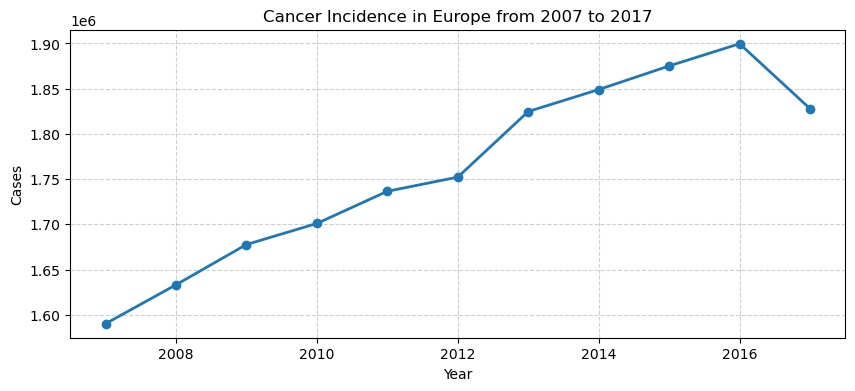

In [174]:
#============================================================================
# 2.-Visualización inicialInitial visualization
#============================================================================

functions_ts.plot_serie(ts_europe, "Cancer Incidence in Europe from 2007 to 2017",'Year', 'Cases')

# 3.- Estadísticas Descriptivas

In [175]:
dict_statistics = functions_ts.descriptive_statistics(ts_europe)
stats_df = pd.DataFrame(dict_statistics, index = [0])
                        
stats_df.style.format('{:,.2f}')


==== Descriptive Statistics ===


,Mean,Median,SD,Min,Max,Range,CV
0,"1,760,633.18","1,752,191.00","102,591.52","1,590,155.00","1,899,646.00","309,491.00",5.83


In [176]:

#============================================================================
# 3.-Descriptive Statistics
#============================================================================

print ("==== Descriptive Statistics ===")
print (f"Mean: {ts_europe.mean():.2f}")
print (f"Median: {ts_europe.median():.2f}")
print (f"SD: {ts_europe.std():.2f}")
print (f"Min: {ts_europe.min():.2f}")
print (f"Max: {ts_europe.max():.2f}")
print (f"Range: {ts_europe.max() - ts_europe.min():.2f}")
print (f"CV (%): {(ts_europe.std() / ts_europe.mean()) * 100:.2f} %\n")


==== Descriptive Statistics ===
Mean: 1760633.18
Median: 1752191.00
SD: 102591.52
Min: 1590155.00
Max: 1899646.00
Range: 309491.00
CV (%): 5.83 %



# 4.- Revisamos si la serie es estacionaria.

In [177]:
dikey_fuller_check = functions_ts.chequear_estacionaridad(ts_europe)
print(pd.DataFrame(dikey_fuller_check))

===== Stationary Tests =======
ADF Statistic: -1.9000
P-value: 0.3320
--- KPSS Test ---
Kpss Statistics: 0.1380
P-value: approx. 0.06483907586418478
Interpretation: Series is STATIONARY (fail to reject H0)

     test_name  estadistico    valorp  \
0  dikeyfuller    -1.900048  0.332038   
1         kpss     0.137987  0.064839   

                                 interpretacion  
0  Series is NON-STATIONARY (fail to reject H0)  
1      Series is STATIONARY (fail to reject H0)  


In [178]:
#============================================================================
# 4.-Test de estacionariedad
#============================================================================

print("===== Stationary Tests =======")

# 4.1 Augmented Dickey-Fuller Test
print('---- Augmented Dikey-Fuller Tests --- ')
# R's adf.test has default lag determined by a formula
adf_result = adfuller(ts_europe, autolag='AIC')
adf_stat = adf_result[0]
adf_pvalue = adf_result[1]
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"P-value: {adf_pvalue:.4f}")
adf_interpretation = "Series is STATIONARY (reject H0)" if adf_pvalue < 0.05 else "Series is NON-STATIONARY (fail to reject H0)"
print(f"Interpretation: {adf_interpretation}\n")

# 4.2 KPSS Test
print("--- KPSS Test ---")
# R's kpss.test(ts, null="Trend") corresponds to regression='ct' in Python.
# R's default null="Level" corresponds to regression='c' in Python.
# The R script uses 'Trend', so we'll use 'ct'
kpss_result = kpss(ts_europe, regression='ct', nlags='auto')
kpss_stat = kpss_result[0]
kpss_pvalue = kpss_result[1] # Note: Python's KPSS returns a truncated p-value
kpss_critical = kpss_result[3]
print(f"Kpss Statistics: {kpss_stat:.4f}")
# The p-value for KPSS is often not a precise value, but a range.
# We'll compare to a common significance level (e.g., 5%)
is_kpss_stationary = kpss_stat < kpss_critical['5%']
kpss_interpretation = "Series is STATIONARY (fail to reject H0)" if is_kpss_stationary else "Series is NON-STATIONARY (reject H0)"
print(f"P-value: approx. {kpss_pvalue}")
print(f"Interpretation: {kpss_interpretation}\n")

# 4.3 Philips-Perron Test (Skipped for simplicity in Python equivalent)
# There is no direct, simple PP.test equivalent in the standard statsmodels.

# 4.4 Combined Interpretaion
print("--- Combined Stationary Assessment --- ")
if adf_pvalue < 0.05 and is_kpss_stationary:
    print("CONCLUSION: Series is likely STATIONARY\n")
elif adf_pvalue >= 0.05 and not is_kpss_stationary:
    print("CONCLUSION: Tests disagree - series may be trend stationary")
    print("RECOMMENDATION: Consider detrending rather than differencing \n")
else:
    print("CONCLUSION: Tests disagree - further investigation needed \n")


===== Stationary Tests =======
---- Augmented Dikey-Fuller Tests --- 
ADF Statistic: -1.9000
P-value: 0.3320
Interpretation: Series is NON-STATIONARY (fail to reject H0)

--- KPSS Test ---
Kpss Statistics: 0.1380
P-value: approx. 0.06483907586418478
Interpretation: Series is STATIONARY (fail to reject H0)

--- Combined Stationary Assessment --- 
CONCLUSION: Tests disagree - further investigation needed 



# 5.- Revisamos Autocorrelacion de la serie

=== Autocorrelation Analysis ===

--- Ljung-Box Test (lag = 10) ---
Chi-squared: 41.1073
P-value: 0.0000
Interpretation: Significant autocorrelation detected



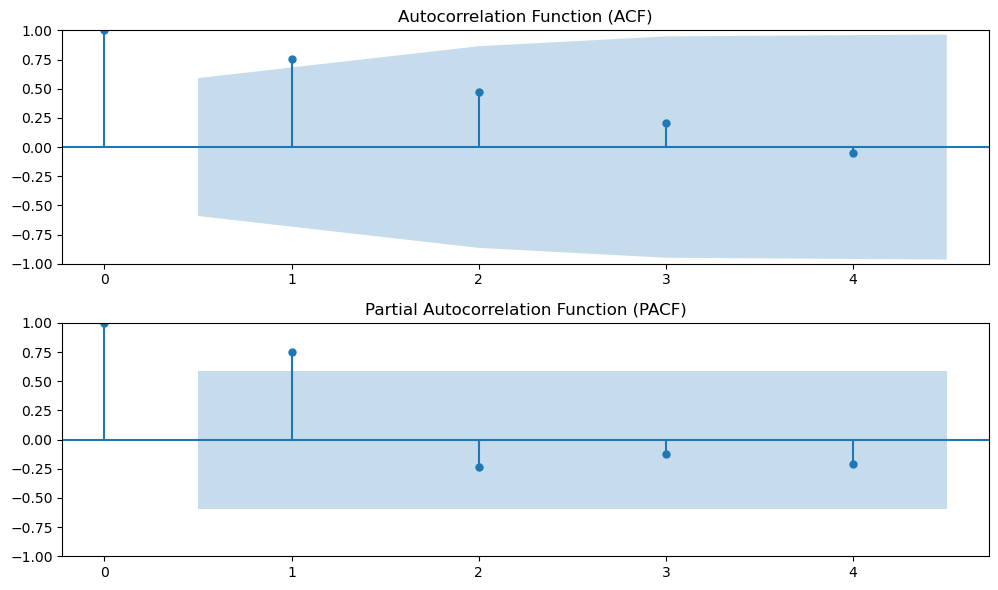

In [179]:
autocorrelation_check = functions_ts.chequear_autocorrelacion(ts_europe, alpha = 0.05, number_lags = 10)

=== Autocorrelation Analysis ===



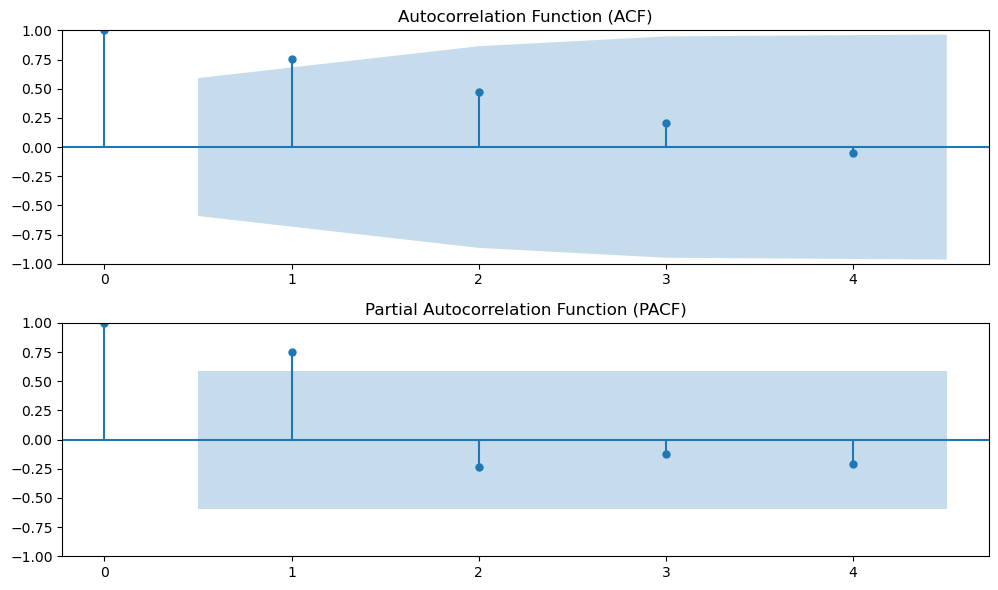

--- Ljung-Box Test (lag = 10) ---
Chi-squared: 41.1073
P-value: 0.0000
Interpretation: Significant autocorrelation detected



In [180]:
#============================================================================
# 5.-Autocorrelation
#============================================================================

print("=== Autocorrelation Analysis ===\n")

# 5.1 ACF and PACF plots
# 
# 
fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(ts_europe, lags=min(20, len(ts_europe)//2 - 1), ax=axes[0], title="Autocorrelation Function (ACF)")
plot_pacf(ts_europe, lags=min(20, len(ts_europe)//2 - 1), ax=axes[1], title="Partial Autocorrelation Function (PACF)")
plt.tight_layout()
plt.show()

# 5.2 Ljung-Box Test for autocorrelation
print("--- Ljung-Box Test (lag = 10) ---")
# statsmodels' acorr_ljungbox returns a DataFrame, lag is the number of lags tested.
lb_result = acorr_ljungbox(ts_europe, lags=[10])
lb_stat = lb_result.loc[10, 'lb_stat']
lb_pvalue = lb_result.loc[10, 'lb_pvalue']
print(f"Chi-squared: {lb_stat:.4f}")
print(f"P-value: {lb_pvalue:.4f}")
lb_interpretation = "Significant autocorrelation detected" if lb_pvalue < 0.05 else "No significant autocorrelation"
print(f"Interpretation: {lb_interpretation}\n")


=== Autocorrelation Analysis ===

--- Ljung-Box Test (lag = 10) ---
Chi-squared: 41.1073
P-value: 0.0000
Interpretation: Significant autocorrelation detected



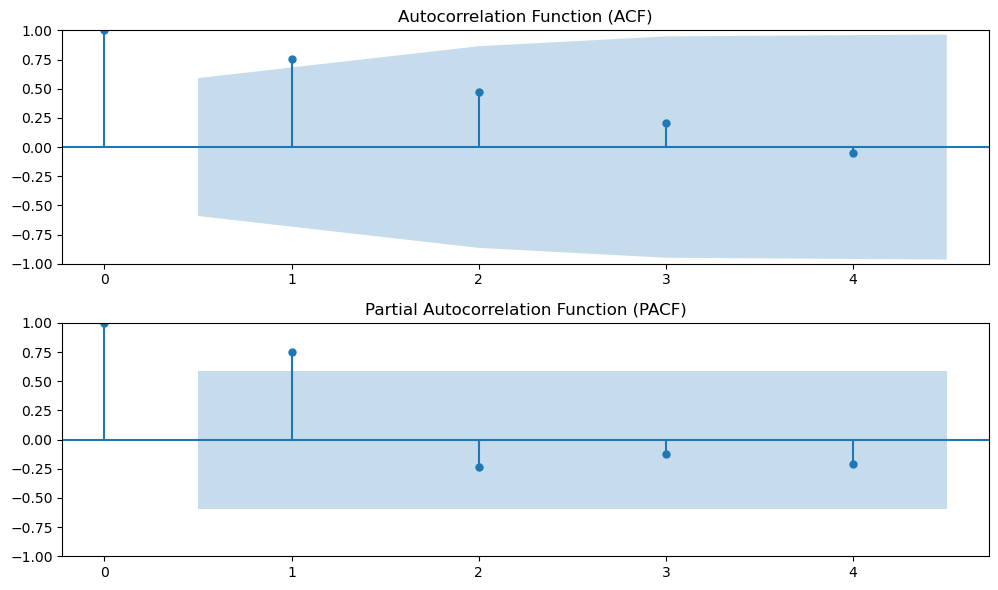

In [181]:
fig, axes, lb_df =  functions_ts.chequear_autocorrelacion(ts_europe)

# 6.- Descomponer la serie para análisis

=== Time Series Decomposition ===


STL decomposition skipped: no seasonality in annual data


--- Moving Average Trend Extraccion ---


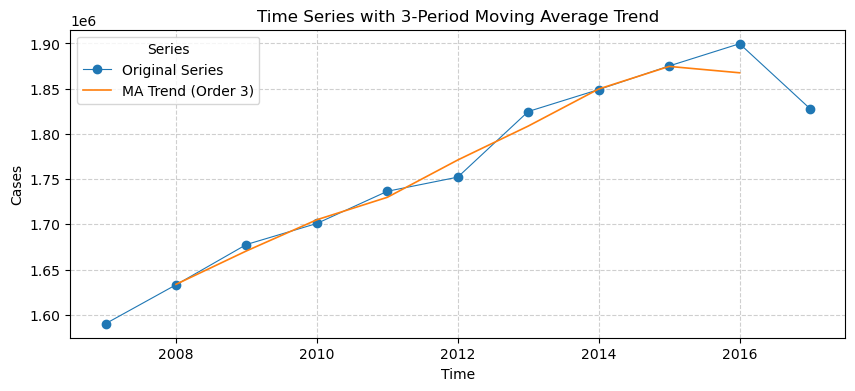


Detrended series statistics:
count        9.000000
mean      4252.259259
std      14142.774430
min     -18961.333333
25%       -622.333333
50%        514.666667
75%       7093.333333
max      32126.666667
Name: y, dtype: float64


In [182]:
#============================================================================
# 6.- Decomposition Methods
#============================================================================

print("=== Time Series Decomposition ===\n")

# Annual data: frequency = 1. R code skips full decomposition.
# We will use simple moving average for trend extraction.

# The R script has a check for frequency > 1, so STL and seasonal decomposition
# are skipped for annual data. We will echo this.

if 1 > 1: # frequency(ts_europe) > 1 (which is 1)
    # This block is skipped for annual data, just like in the R script.
    pass
else:
    print("\nSTL decomposition skipped: no seasonality in annual data\n")

# 6.4 Moving Average Decomposition (for trend extraction)
print("\n--- Moving Average Trend Extraccion ---")

# Choose appropriate window (e.g., 3-year moving average for annual data)
ma_order = min(5, len(ts_europe) // 3) # Adaptive order
# center=True for R's centre=TRUE (centered moving average)
ma_trend = ts_europe.rolling(window=ma_order, center=True).mean()

# Plot original vs trend
# 
plt.figure(figsize=(10, 4))
ts_europe.plot(label='Original Series', linewidth=0.8, marker='o')
ma_trend.plot(label=f'MA Trend (Order {ma_order})', linewidth=1.2)
plt.title(f"Time Series with {ma_order}-Period Moving Average Trend")
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend(title='Series')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Detrended series
detrended = ts_europe - ma_trend
print("\nDetrended series statistics:")
print(detrended.dropna().describe())


# 7.- Rolling Statistics (Nos ayudaran a identificar puntos de inflexion en la serie)


=== Rolling Statistics Analysis ===

Variance stability check:
Variance ratio: 0.79
------------------------------
Variance ratio is within acceptable limits.
Windows size observations: 3
ds
2007             NaN
2008             NaN
2009    1.633671e+06
2010    1.670610e+06
2011    1.705073e+06
2012    1.729903e+06
2013    1.771152e+06
2014    1.808626e+06
2015    1.849588e+06
2016    1.874563e+06
2017    1.867519e+06
Name: y, dtype: float64
ds
2007             NaN
2008             NaN
2009    43776.286781
2010    34460.946219
2011    29634.624046
2012    26247.608164
2013    47046.794421
2014    50355.108231
2015    25184.267635
2016    25343.919613
2017    36497.820720
Name: y, dtype: float64
   window_size  half_len  first_half_var  second_half_var  variance_ratio  \
0            3         5    3.288343e+09     2.587619e+09        0.786906   

  warning recommendation                        variance_check_result  
0                         Variance ratio is within acceptable limits

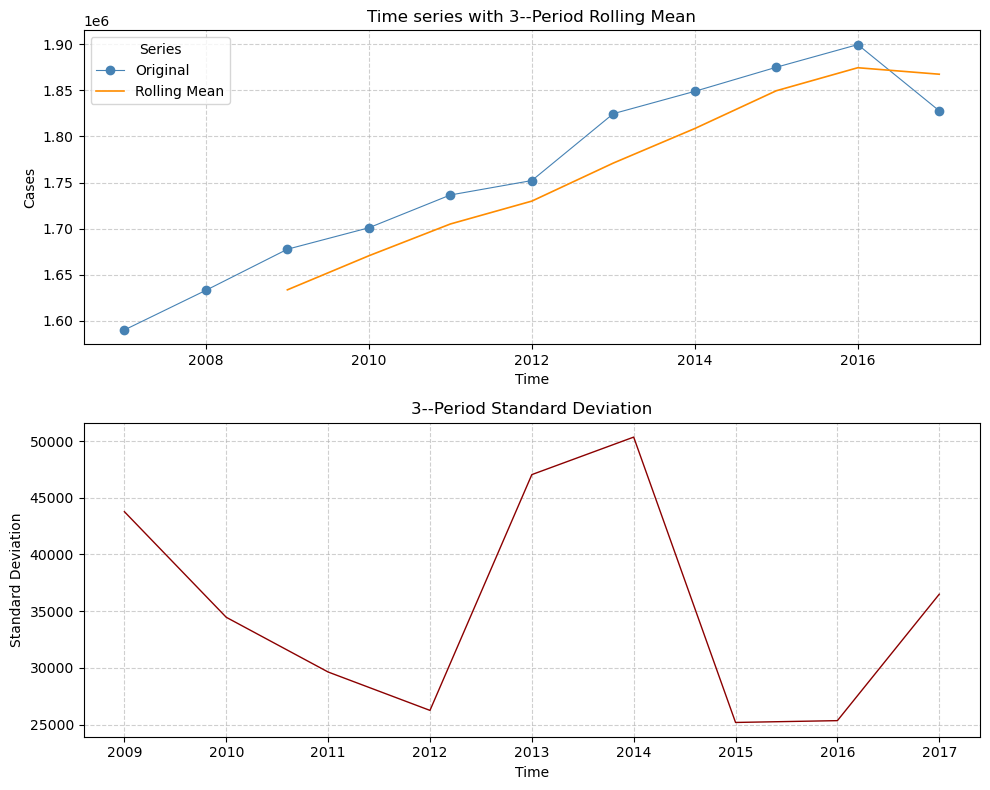

In [184]:
fig, axes, rolling_mean, rolling_sd, df_rolling = functions_ts.calculate_rolling_statistics(ts_europe)
print(f"Windows size observations: {window_size_observations}")
print(rolling_mean)
print(rolling_sd)
print(df_rolling)


=== Rolling Statistics Analysis ===


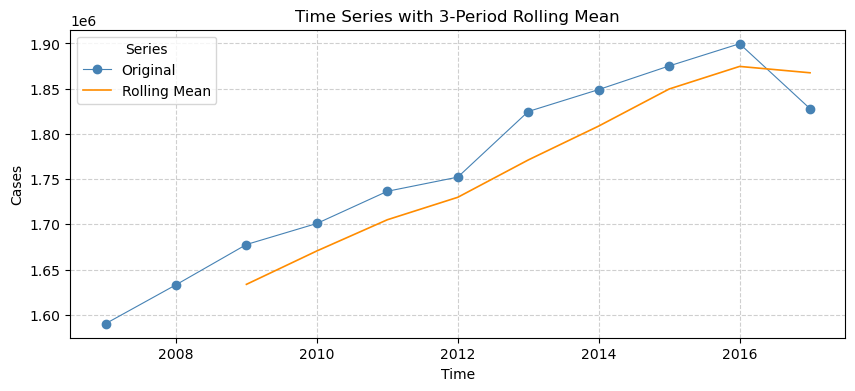

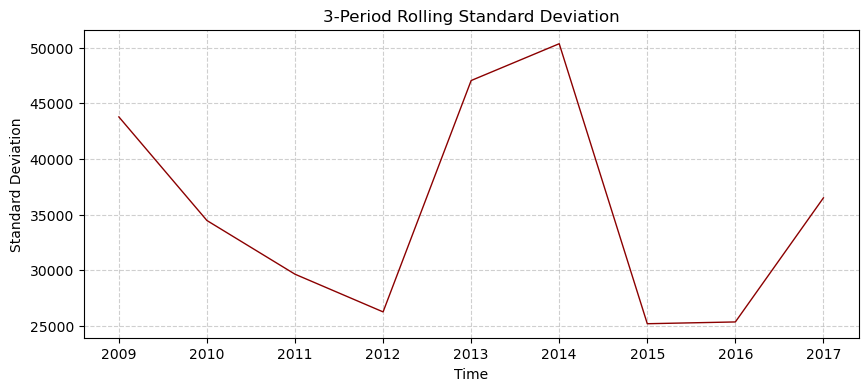


Variance stability check:
First half variance: 3288343247.70
Second half variance: 2587618550.27
Variance ratio: 0.79


In [133]:
#============================================================================
# 7.- Rolling Statistics
#============================================================================

print("\n=== Rolling Statistics Analysis ===")

# Calculate rolling mean and standard deviation
window_size = min(5, len(ts_europe) // 3)

# align = "right" in R corresponds to no center=True in pandas, and min_periods=1
rolling_mean = ts_europe.rolling(window=window_size).mean()
rolling_sd = ts_europe.rolling(window=window_size).std()

# Plot rolling statistics
# 
plt.figure(figsize=(10, 4))
ts_europe.plot(label='Original', linewidth=0.8, color='steelblue', marker='o')
rolling_mean.plot(label='Rolling Mean', linewidth=1.2, color='darkorange')
plt.title(f"Time Series with {window_size}-Period Rolling Mean")
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend(title='Series')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot rolling standard deviation
# 
plt.figure(figsize=(10, 4))
rolling_sd.plot(linewidth=1, color='darkred')
plt.title(f"{window_size}-Period Rolling Standard Deviation")
plt.xlabel('Time')
plt.ylabel('Standard Deviation')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Test for changing variance (similar to R script)
print("\nVariance stability check:")
half_len = len(ts_europe) // 2
first_half_var = ts_europe.iloc[:half_len].var()
second_half_var = ts_europe.iloc[half_len:].var()

print(f"First half variance: {first_half_var:.2f}")
print(f"Second half variance: {second_half_var:.2f}")

if first_half_var > 0:
    variance_ratio = second_half_var / first_half_var
    print(f"Variance ratio: {variance_ratio:.2f}")
    if np.abs(np.log(variance_ratio)) > 0.5:
        print("WARNING: Variance appears to be changing over time ")
        print("RECOMMENDATION: Consider log transformation or variance stabilization")
else:
    print("Cannot compute variance ratio (First half variance is zero or negative).")


# 8.- Análisis de la necesidad de transformar la serie temporal


=== Transformation Analysis ===

--- Box-Cox Transformation ---
Optimal Lambda: 3.43
Interpretation: Power transformation with lambda = 3.428


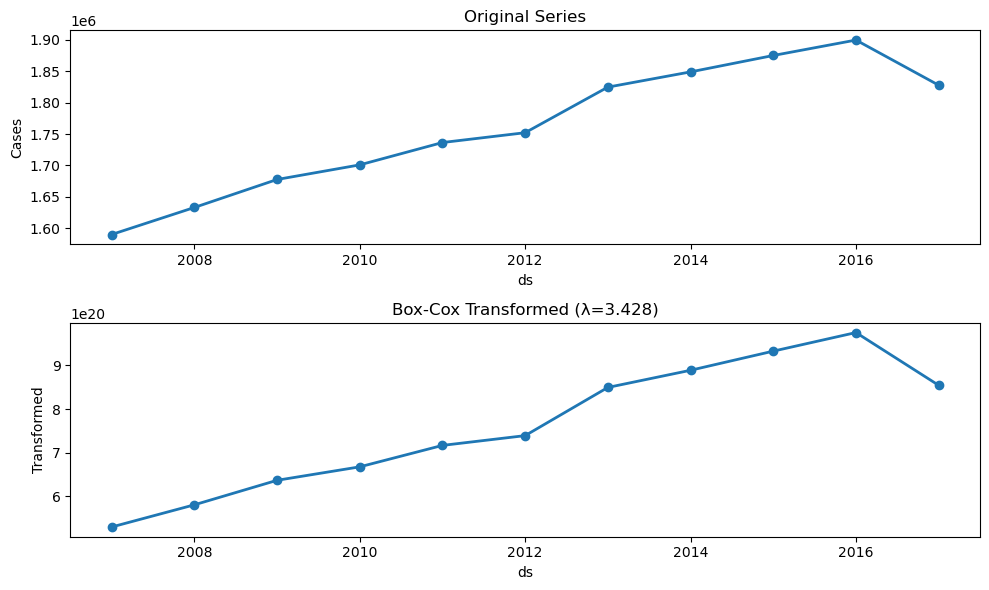


--- Log Transformation ---
Original CV: 0.0583
Log-transformed CV: 0.0041


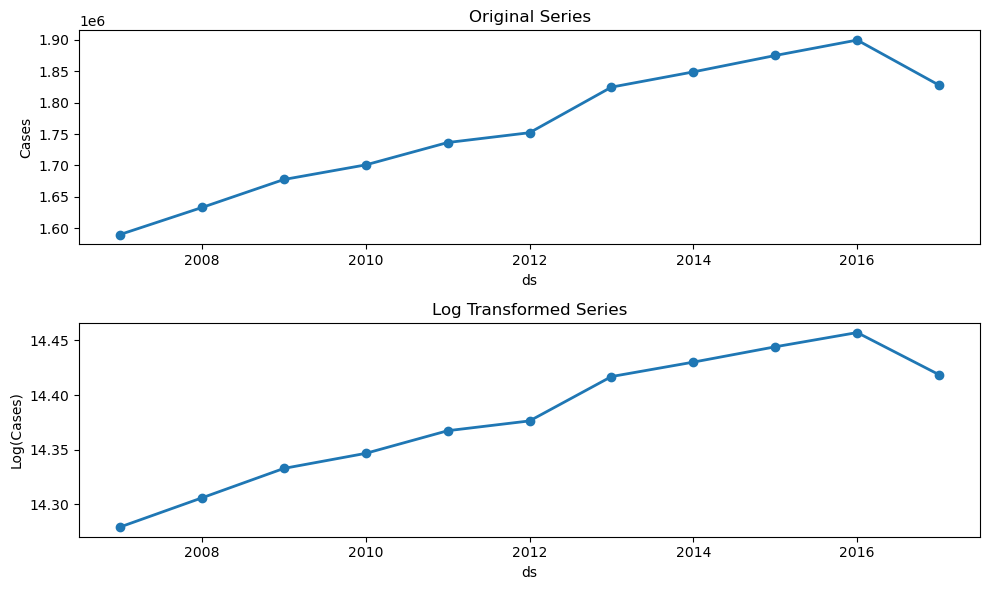


--- First Differencing ---
Original Series - ADF p-value: 0.3320
First differenced - ADF p-value: 0.1849


<Figure size 1000x300 with 0 Axes>

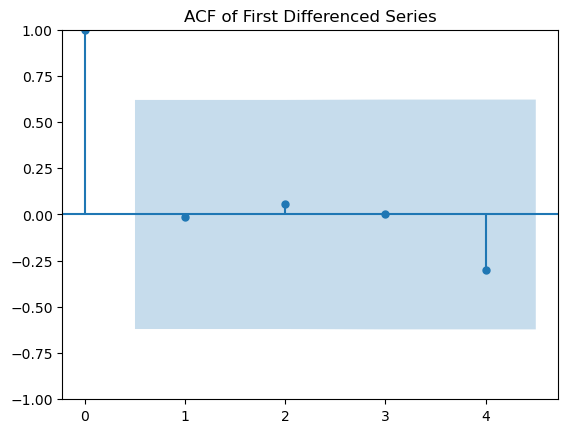

Date range: 1953-12-31 to 2017-12-31
Number of observations: 65
Missing values in y: 0



In [16]:
#============================================================================
# 8. Transformation Analysis
#============================================================================

print("\n=== Transformation Analysis ===")

# 8.1 Box-Cox Transformation
if ts_europe.min() > 0:
    print("\n--- Box-Cox Transformation ---")

    # Box-Cox.lambda in R is equivalent to the first return of scipy.stats.boxcox
    ts_transformed, lambda_opt = boxcox(ts_europe)
    print(f"Optimal Lambda: {lambda_opt:.2f}")

    # Interpretation of Lambda
    if np.abs(lambda_opt) < 0.1:
        print("Interpretation: Log Transformation recommended (lambda ≈ 0)")
    elif np.abs(lambda_opt - 0.5) < 0.1:
        print("Interpretation: Square root transformation recommended (lambda ≈ 0.5)")
    elif np.abs(lambda_opt - 1) < 0.1:
        print("Interpretation: No transformation needed (lambda ≈ 1)")
    else:
        print(f"Interpretation: Power transformation with lambda = {lambda_opt:.3f}")

    # Plot comparison
    # 
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    ts_europe.plot(ax=axes[0], title="Original Series", ylabel="Cases", linewidth=2, marker='o')
    pd.Series(ts_transformed, index=ts_europe.index).plot(
        ax=axes[1], title=f"Box-Cox Transformed (λ={lambda_opt:.3f})", ylabel="Transformed", linewidth=2, marker='o'
    )
    plt.tight_layout()
    plt.show()

else:
    print("Box-Cox transformation skipped: data contains non-positive values\n")

# 8.2 Log Transformation (if aplicable)
if ts_europe.min() > 0:
    ts_log = np.log(ts_europe)
    print("\n--- Log Transformation ---")
    print(f"Original CV: {ts_europe.std() / ts_europe.mean():.4f}")
    print(f"Log-transformed CV: {ts_log.std() / ts_log.mean():.4f}")

    # Plot
    # 
    fig, axes = plt.subplots(2, 1, figsize=(10, 6))
    ts_europe.plot(ax=axes[0], title="Original Series", ylabel="Cases", linewidth=2, marker='o')
    ts_log.plot(ax=axes[1], title="Log Transformed Series", ylabel="Log(Cases)", linewidth=2, marker='o')
    plt.tight_layout()
    plt.show()

# 8.3 First Difference
ts_diff1 = ts_europe.diff().dropna()

print("\n--- First Differencing ---")
# ADF test on original and differenced series
adf_orig_p = adfuller(ts_europe, autolag='AIC')[1]
adf_diff1_p = adfuller(ts_diff1, autolag='AIC')[1]
print(f"Original Series - ADF p-value: {adf_orig_p:.4f}")
print(f"First differenced - ADF p-value: {adf_diff1_p:.4f}")

if adf_diff1_p < 0.05:
    print("First differencing achieves stationarity")

# Plot of differenced series ACF
# 
plt.figure(figsize=(10, 3))
plot_acf(ts_diff1, lags=min(20, len(ts_diff1)//2 - 1), title="ACF of First Differenced Series")
plt.show()

# The R script then calls filtering_item on the full dataset with the first item_id.
# Since the goal is the comprehensive analysis of the *aggregate* series (ts_europe),
# this part is likely for subsequent, more granular analysis.
serie_df = filtering_item(df_cancer_incidence, item_id.head(1))

# Checking for missing dates and completeness (on the granular series)
print(f"Date range: {serie_df['ds'].min().date()} to {serie_df['ds'].max().date()}")
print(f"Number of observations: {len(serie_df)}")
print(f"Missing values in y: {serie_df['y'].isnull().sum()}\n")



# 9.- Análisis de la presencia de tendencia en la serie temporal


=== Trend Analysis ===

--- Linear Trend Model ---
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     82.37
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           7.97e-06
Time:                        19:08:48   Log-Likelihood:                -129.26
No. Observations:                  11   AIC:                             262.5
Df Residuals:                       9   BIC:                             263.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------


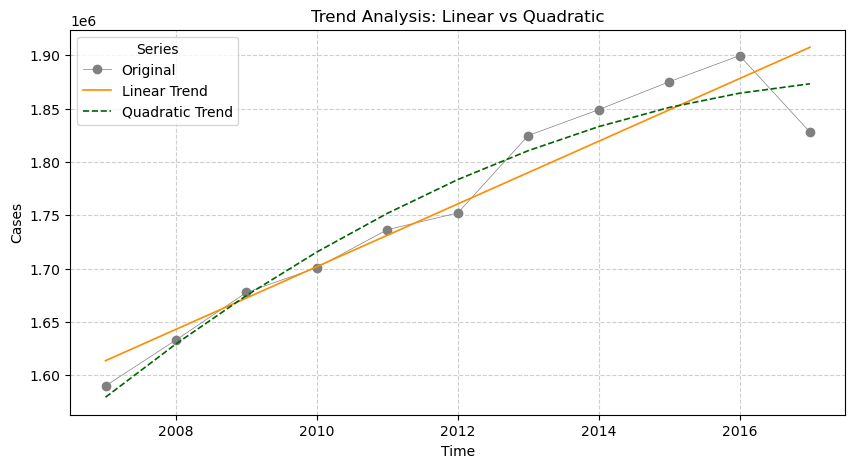

In [17]:
#============================================================================
# 9.- Trend Analysis
#============================================================================

print("\n=== Trend Analysis ===")

# 9.1 Linear Trend
time_index = np.arange(1, len(ts_europe) + 1)
Y = ts_europe.values
X = sm.add_constant(time_index) # Add constant for intercept

# Fit the linear model using OLS (R's lm equivalent)
linear_model = sm.OLS(Y, X).fit()

print("\n--- Linear Trend Model ---")
print(linear_model.summary())

# Extract coefficients
intercept = linear_model.params[0]
slope = linear_model.params[1]

# Extract p-values
p_value_intercept = linear_model.pvalues[0]
p_value_slope = linear_model.pvalues[1]

print("\nTrend Interpretation:")
print(f"Starting level: {intercept:.2f}")
print(f"Annual change: {slope:.2f} cases per year")
print(f"Percentage change per year: {(slope/intercept)*100:.2f} %")
print("\nP-values:")
print(f"Intercept p-value: {p_value_intercept:.4f}")
print(f"Slope p-value: {p_value_slope:.4f}\n")

if p_value_slope < 0.05:
    if slope > 0:
        print("Significant increasing trend detected (p < 0.05)")
    else:
        print("Significant decreasing trend detected (p < 0.05)")
else:
    print("No significant trend detected (p >= 0.05)")


# 9.2 Polynomial trend (quadratic)
time_index_sq = time_index**2
X_poly = np.column_stack([time_index, time_index_sq])
X_poly = sm.add_constant(X_poly)

poly_model = sm.OLS(Y, X_poly).fit()

print("\n--- Quadratic Trend Model ---")
print(poly_model.summary())

# Compare models
print("\nModel Comparison:")
print(f"Linear R²: {linear_model.rsquared:.4f}")
print(f"Quadratic R²: {poly_model.rsquared:.4f}")

# AIC comparison
print(f"Linear AIC: {linear_model.aic:.2f}")
print(f"Quadratic AIC: {poly_model.aic:.2f}")


# 9.3 Plot trends
fitted_linear = linear_model.fittedvalues
fitted_poly = poly_model.fittedvalues

# 
plt.figure(figsize=(10, 5))
plt.plot(ts_europe.index, ts_europe.values, label='Original', color='gray', linewidth=0.5, marker='o')
plt.plot(ts_europe.index, fitted_linear, label='Linear Trend', color='darkorange', linewidth=1.2)
plt.plot(ts_europe.index, fitted_poly, label='Quadratic Trend', color='darkgreen', linewidth=1.2, linestyle='--')
plt.title("Trend Analysis: Linear vs Quadratic")
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend(title='Series')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()



# 10.- Análisis de estacionalidad en la serie temporal

In [18]:

#============================================================================
# 10.- Seasonality Analysis (if applicable)
#============================================================================

if 1 > 1: # frequency(ts_europe) > 1 (which is 1)
    pass # This block is skipped for annual data, just like in the R script.
else:
    print("\n=== No seasonality (Annual Data) ===\n")



=== No seasonality (Annual Data) ===



# 11. Detección de Outliers


=== Outlier Detection ===
IQR Method:
Lower bound: 1465743.75
Upper bound: 2061993.75
Number of outliers: 0

Z-score Method (|z| > 3):
Number of outliers: 0


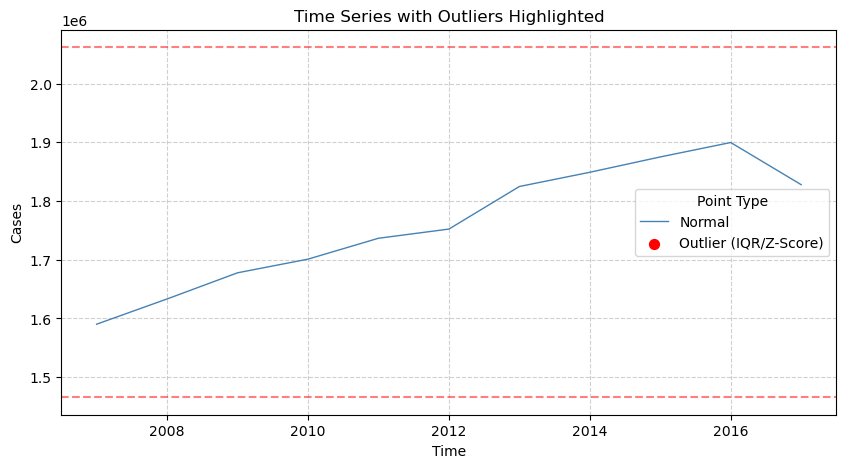

In [19]:


#============================================================================
# 11.- Outlier Detection
#============================================================================

print("\n=== Outlier Detection ===")

# 11.1 Statistical outliers (using IQR method)
Q1 = ts_europe.quantile(0.25)
Q3 = ts_europe.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = ts_europe[(ts_europe < lower_bound) | (ts_europe > upper_bound)]

print("IQR Method:")
print(f"Lower bound: {lower_bound:.2f}")
print(f"Upper bound: {upper_bound:.2f}")
print(f"Number of outliers: {len(outliers_iqr)}")

if len(outliers_iqr) > 0:
    print("Outlier position (Year):", outliers_iqr.index.tolist())
    print("Outlier values:", outliers_iqr.values.tolist())

# 11.2 Z-scored method
z_scores = (ts_europe - ts_europe.mean()) / ts_europe.std()
outliers_z = ts_europe[np.abs(z_scores) > 3]

print("\nZ-score Method (|z| > 3):")
print(f"Number of outliers: {len(outliers_z)}")

if len(outliers_z) > 0:
    print("Outlier positions (Year):", outliers_z.index.tolist())
    print("Outlier values:", outliers_z.values.tolist())
    print("Z-scores:", z_scores[outliers_z.index].tolist())

# Plot with outliers highlighted
# Combine outliers from both methods
outlier_years = np.union1d(outliers_iqr.index, outliers_z.index)
is_outlier = ts_europe.index.isin(outlier_years)

# 
plt.figure(figsize=(10, 5))
plt.plot(ts_europe.index, ts_europe.values, color='steelblue', linewidth=1, label='Normal')
plt.scatter(ts_europe.index[is_outlier], ts_europe.values[is_outlier],
            color='red', s=50, label='Outlier (IQR/Z-Score)', zorder=5)
plt.axhline(lower_bound, color='red', linestyle='--', alpha=0.5)
plt.axhline(upper_bound, color='red', linestyle='--', alpha=0.5)
plt.title("Time Series with Outliers Highlighted")
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend(title='Point Type')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# 12.- Detección de puntos de cambio en la serie temporal


=== Change Point Detection ===


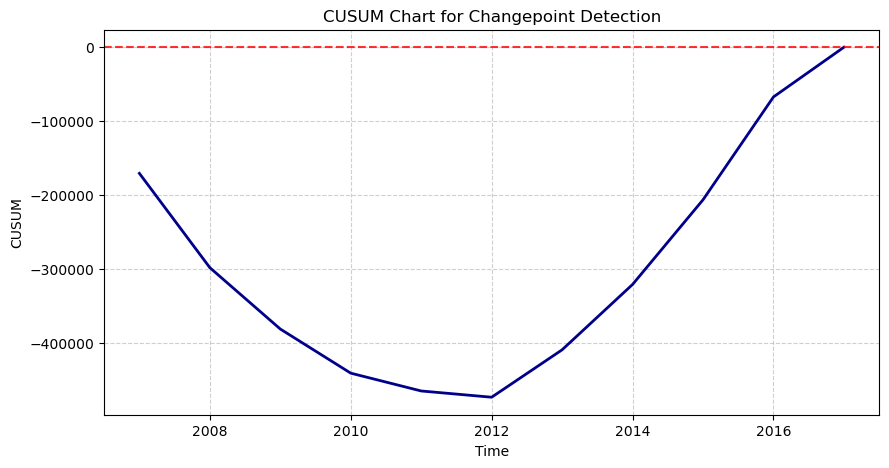

Potential changepoints at positions (1-based index): [6]
Potential changepoint years: [2012]


In [20]:



#============================================================================
# 12.- Change Point Detection
#============================================================================

print("\n=== Change Point Detection ===")

# Simple CuSum approach
# R's cumsum(ts - mean(ts))
cumsum_vals = (ts_europe - ts_europe.mean()).cumsum()

# 
plt.figure(figsize=(10, 5))
plt.plot(ts_europe.index, cumsum_vals, label='CUSUM', color='darkblue', linewidth=2)
plt.axhline(0, color='red', linestyle='--', alpha=0.8)
plt.title("CUSUM Chart for Changepoint Detection")
plt.xlabel("Time")
plt.ylabel("CUSUM")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Identify potential checkpoints (local maxima/minima) using scipy.signal.find_peaks
# In CUSUM, local extrema (peaks/troughs) often signal a change point.
# We look for peaks in the absolute value of CUSUM or local extrema of CUSUM itself.
# Using CUSUM itself:
peaks, _ = find_peaks(cumsum_vals)
troughs, _ = find_peaks(-cumsum_vals)
potential_changes_idx = np.unique(np.concatenate([peaks, troughs]))
potential_changes = potential_changes_idx + 1 # +1 for R's 1-based indexing correction

print("Potential changepoints at positions (1-based index):", potential_changes.tolist())
if len(potential_changes) > 0:
    potential_change_years = ts_europe.index[potential_changes - 1].tolist()
    print("Potential changepoint years:", potential_change_years)


# 13.- Diagnosticos Gráficos de la serie temporal


=== Generating Summary Visualizations ===


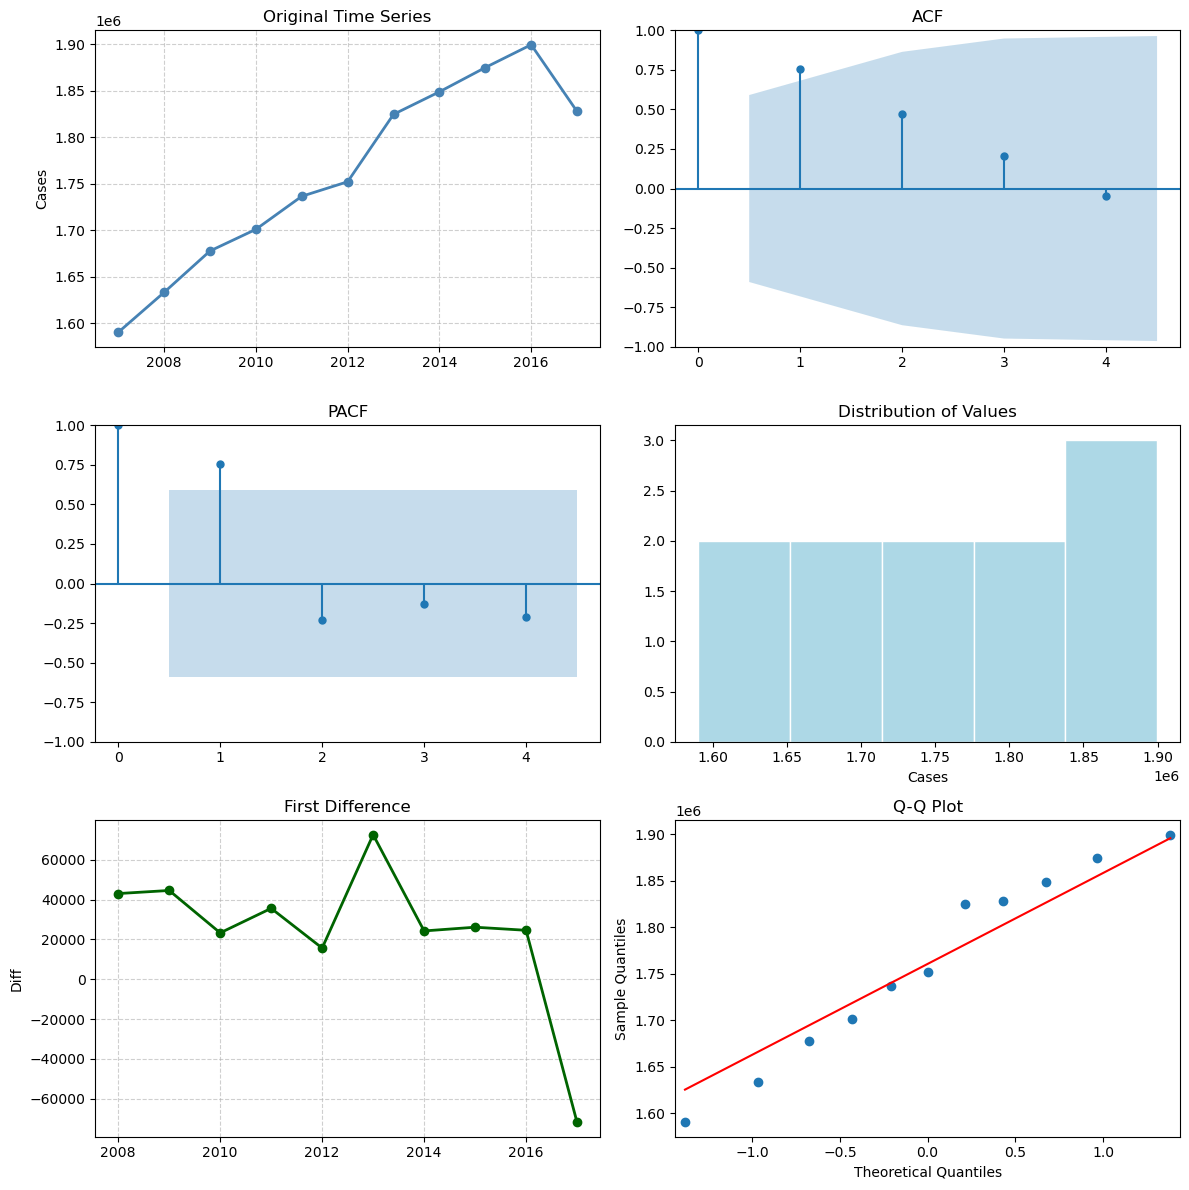

In [21]:

#============================================================================
# 13.- Summary Visualizations
#============================================================================

print("\n=== Generating Summary Visualizations ===")

# Create a comprehensive multi-panel plot
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# Panel 1: Original series
axes[0, 0].plot(ts_europe.index, ts_europe.values, color='steelblue', linewidth=2, marker='o')
axes[0, 0].set_title("Original Time Series")
axes[0, 0].set_ylabel("Cases")
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

# Panel 2: ACF
plot_acf(ts_europe, lags=min(20, len(ts_europe)//2 - 1), ax=axes[0, 1], title="ACF")

# Panel 3: PACF
plot_pacf(ts_europe, lags=min(20, len(ts_europe)//2 - 1), ax=axes[1, 0], title="PACF")

# Panel 4: Histogram
axes[1, 1].hist(ts_europe, bins=min(10, len(ts_europe)//2), color='lightblue', edgecolor='white')
axes[1, 1].set_title("Distribution of Values")
axes[1, 1].set_xlabel("Cases")

# Panel 5: First difference (Note: R plot has first difference in this panel, not original series)
axes[2, 0].plot(ts_diff1.index, ts_diff1.values, color='darkgreen', linewidth=2, marker='o')
axes[2, 0].set_title("First Difference")
axes[2, 0].set_ylabel("Diff")
axes[2, 0].grid(True, linestyle='--', alpha=0.6)

# Panel 6: QQ plot
sm.qqplot(ts_europe.values, line='s', ax=axes[2, 1])
axes[2, 1].set_title("Q-Q Plot")

plt.tight_layout()
plt.show()
# 


# 14.- Resumen de las caracteristicas de la serie temporal

In [22]:

#============================================================================
# 14.- Comprehensive Summary Report
#============================================================================

# Trend significance: The R code is complex and potentially flawed in its p-value extraction.
# We rely on the correct p-value from the linear_model summary.
trend_p_value = linear_model.pvalues[1] # P-value for the slope (time_index)

print("\n")
print("=" * 70)
print("                       Comprehensive Time Series Analysis Summary")
print("=" * 70)
print("\nData Characteristics:")
print(f"    - Period: {ts_europe.index.min()} to {ts_europe.index.max()}")
print(f"    - Observations: {len(ts_europe)}")
print(f"    - Frequency: 1 (Annual)")
print(f"    - Mean: {ts_europe.mean():.2f}")
print(f"    - Standard Deviation: {ts_europe.std():.2f}")
print(f"    - Coefficient of Variation: {(ts_europe.std()/ts_europe.mean()*100):.2f} %")
print("\nTrend:")
print(f"    - Linear trend slope: {slope:.3f} cases/year")
print(f"    - Trend significance: p={trend_p_value:.4f}")
print(f"    - Trend is: {'SIGNIFICANT' if trend_p_value < 0.05 else 'NO SIGNIFICANT'}")
print("\nAutocorrelation:")
print(f"    - Ljung-Box Test: p = {lb_pvalue:.4f}")
print(f"    - Autocorrelation: {'PRESENT' if lb_pvalue < 0.05 else 'NO SIGNIFICANT'}")
print("\nOutliers:")
print(f"    - IQR method: {len(outliers_iqr)} outliers detected")
print(f"    - Z-score method: {len(outliers_z)} outliers detected")
print("\nRecommendations:")

if adf_pvalue >= 0.05:
    print("    1. Series is non-stationary - consider differencing or detrending")

if adf_pvalue >= 0.05 and not is_kpss_stationary: # Combined stationary test failure (ADF non-stationary, KPSS non-stationary)
    print("    2. Apply first differencing before modelling")

if first_half_var > 0 and np.abs(np.log(variance_ratio)) > 0.5:
    print("    3. Variance is not constant - consider transformation (log or Box-Cox)")

if lb_pvalue < 0.05:
    print("    4. Significant autocorrelation present - use ARIMA or similar models")

if len(outliers_iqr) > 0 or len(outliers_z) > 0:
    print("    5. Outliers detected - investigate and consider robust methods")

if trend_p_value < 0.05:
    print("    6. Significant trend present - incorporate trend in forecasting models")

print("\n")
print("=" * 70)
print("                          Analysis Complete")
print("=" * 70)




                       Comprehensive Time Series Analysis Summary

Data Characteristics:
    - Period: 2007 to 2017
    - Observations: 11
    - Frequency: 1 (Annual)
    - Mean: 1760633.18
    - Standard Deviation: 102591.52
    - Coefficient of Variation: 5.83 %

Trend:
    - Linear trend slope: 29369.564 cases/year
    - Trend significance: p=0.0000
    - Trend is: SIGNIFICANT

Autocorrelation:
    - Ljung-Box Test: p = 0.0000
    - Autocorrelation: PRESENT

Outliers:
    - IQR method: 0 outliers detected
    - Z-score method: 0 outliers detected

Recommendations:
    1. Series is non-stationary - consider differencing or detrending
    4. Significant autocorrelation present - use ARIMA or similar models
    6. Significant trend present - incorporate trend in forecasting models


                          Analysis Complete


# 15.- Guardar los resultados

In [23]:


# ============================================================================
# 15. SAVE RESULTS (Simplified for brevity and standard Python practice)
# ============================================================================

# Simplified saving of key results
save_directory = os.getcwd() # Save to current working directory

# Save statistical tests summary
test_results = pd.DataFrame({
    'Test': ["ADF", "KPSS", "Ljung-Box"],
    'Statistic': [adf_stat, kpss_stat, lb_stat],
    'P_value': [adf_pvalue, kpss_pvalue, lb_pvalue],
    'Result': [
        "Stationary" if adf_pvalue < 0.05 else "Non-stationary",
        "Non-stationary" if not is_kpss_stationary else "Stationary",
        "Autocorrelation Present" if lb_pvalue < 0.05 else "No Autocorrelation"
    ]
})
test_results_path = os.path.join(save_directory, "statistical_tests_summary.csv")
test_results.to_csv(test_results_path, index=False)
print(f"\nStatistical tests summary saved to: {test_results_path}")

# Save trend analysis
trend_results = pd.DataFrame({
    'time': ts_europe.index,
    'observed': ts_europe.values,
    'linear_trend': fitted_linear,
    'quadratic_trend': fitted_poly,
    'detrended_linear': ts_europe.values - fitted_linear
})
trend_results_path = os.path.join(save_directory, "trend_analysis.csv")
trend_results.to_csv(trend_results_path, index=False)
print(f"Trend analysis saved to: {trend_results_path}")

print("\n✓ All analysis results saved!")


Statistical tests summary saved to: /home/jsancheg/git_environment/Europe_Cancer_Incidence/src/data/statistical_tests_summary.csv
Trend analysis saved to: /home/jsancheg/git_environment/Europe_Cancer_Incidence/src/data/trend_analysis.csv

✓ All analysis results saved!


# 16.- Ejemplo de modelamiento de una serie con la libreria Prophet

In [24]:
print(ts_europe)

ds
2007    1590155
2008    1633154
2009    1677703
2010    1700972
2011    1736545
2012    1752191
2013    1824721
2014    1848966
2015    1875078
2016    1899646
2017    1827834
Name: y, dtype: int64


In [25]:
modelo1 = Prophet(
    growth = 'linear',
    yearly_seasonality = False, # Set to True if you suspect yearly patterns
    weekly_seasonality = False, 
    daily_seasonality = False,
    seasonality_mode = 'additive',
    changepoint_prior_scale = 0.05,
    seasonality_prior_scale = 10.0,
    interval_width = 0.95, # 95% intervalo de confianza
    uncertainty_samples = 1000 # Numero de muestras para la estimacion de la incertidumbre
)

In [26]:

modelo2 = Prophet(
    growth = 'logistic',
    yearly_seasonality = False, # Set to True if you suspect yearly patterns
    weekly_seasonality = False, 
    daily_seasonality = False,
    seasonality_mode = 'additive',
    changepoint_prior_scale = 0.05,
    seasonality_prior_scale = 10.0,
    interval_width = 0.95, # 95% intervalo de confianza
    uncertainty_samples = 1000 # Numero de muestras para la estimacion de la incertidumbre
)

# Fitting Prophet models

In [27]:
CAPACITY = 2500000
FLOOR = 0
prophet_df = ts_europe.to_frame(name = 'y')
serie_df = prophet_df.reset_index()
# serie_df = europe_df
serie_df['ds'] = pd.to_datetime(serie_df['ds'], format="%Y")

serie_df['cap'] = CAPACITY
serie_df['floor'] = FLOOR
modelo1.fit(serie_df)
modelo2.fit(serie_df)

19:08:54 - cmdstanpy - INFO - Chain [1] start processing
19:08:54 - cmdstanpy - INFO - Chain [1] done processing
19:08:54 - cmdstanpy - INFO - Chain [1] start processing
19:08:54 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
print(prophet_df)
print(serie_df)

            y
ds           
2007  1590155
2008  1633154
2009  1677703
2010  1700972
2011  1736545
2012  1752191
2013  1824721
2014  1848966
2015  1875078
2016  1899646
2017  1827834
           ds        y      cap  floor
0  2007-01-01  1590155  2500000      0
1  2008-01-01  1633154  2500000      0
2  2009-01-01  1677703  2500000      0
3  2010-01-01  1700972  2500000      0
4  2011-01-01  1736545  2500000      0
5  2012-01-01  1752191  2500000      0
6  2013-01-01  1824721  2500000      0
7  2014-01-01  1848966  2500000      0
8  2015-01-01  1875078  2500000      0
9  2016-01-01  1899646  2500000      0
10 2017-01-01  1827834  2500000      0


# Generar Pronóstico

In [29]:
future1 = modelo1.make_future_dataframe(
    periods = 5,
    freq = 'Y'
)
future2 = modelo2.make_future_dataframe(
    periods = 5,
    freq = 'Y'
)

future2['cap'] = CAPACITY
future2['floor'] = FLOOR

print("Generating predictions...")
forecast1 = modelo1.predict(future1)
forecast2 = modelo2.predict(future2)

Generating predictions...


/home/jsancheg/miniconda3/envs/cancer_incidences/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


# Examinar resultados

In [30]:
future1_forecast = forecast1[['ds', 'yhat','yhat_lower', 'yhat_upper']].tail(5).copy()
future2_forecast = forecast2[['ds', 'yhat','yhat_lower', 'yhat_upper']].tail(5).copy()

print("\n5-year Forecast")
print(future1_forecast)
print(future2_forecast)

future1_forecast['prediction_interval'] = future1_forecast['yhat_upper'] - future1_forecast['yhat_lower']
future2_forecast['prediction_interval'] = future1_forecast['yhat_upper'] - future2_forecast['yhat_lower']

future1_forecast['relative_uncertainty'] = np.where(
    future1_forecast['yhat'] != 0,
    (future1_forecast['yhat_upper'] - future1_forecast['yhat_lower'])/ future1_forecast['yhat'] * 100,
    np.nan
)

future2_forecast['relative_uncertainty'] = np.where(
    future2_forecast['yhat'] != 0,
    (future2_forecast['yhat_upper'] - future2_forecast['yhat_lower'])/ future2_forecast['yhat'] * 100,
    np.nan
)





5-year Forecast
           ds          yhat    yhat_lower    yhat_upper
11 2017-12-31  1.880516e+06  1.842414e+06  1.920637e+06
12 2018-12-31  1.888766e+06  1.849921e+06  1.933601e+06
13 2019-12-31  1.897016e+06  1.851068e+06  1.944261e+06
14 2020-12-31  1.905289e+06  1.851497e+06  1.964806e+06
15 2021-12-31  1.913539e+06  1.845491e+06  1.983945e+06
           ds          yhat    yhat_lower    yhat_upper
11 2017-12-31  1.929848e+06  1.873327e+06  1.989633e+06
12 2018-12-31  1.954746e+06  1.900146e+06  2.011303e+06
13 2019-12-31  1.978850e+06  1.921095e+06  2.033943e+06
14 2020-12-31  2.002223e+06  1.949670e+06  2.059631e+06
15 2021-12-31  2.024739e+06  1.964238e+06  2.076945e+06


In [31]:
print("\n Forecast with uncertainty metrics")
future1_forecast_display = future1_forecast.copy()
future1_forecast_display['yhat'] = future1_forecast_display['yhat'].round(1)
future1_forecast_display['yhat_lower'] = future1_forecast_display['yhat_lower'].round(1)
future1_forecast_display['yhat_upper'] = future1_forecast_display['yhat_upper'].round(1)
future1_forecast_display['prediction_interval'] = future1_forecast_display['prediction_interval'].round(1)
future1_forecast_display['relative_uncertainty'] = future1_forecast_display['relative_uncertainty'].round(1)

print(future1_forecast_display)



 Forecast with uncertainty metrics
           ds       yhat  yhat_lower  yhat_upper  prediction_interval  \
11 2017-12-31  1880515.5   1842414.4   1920636.9              78222.4   
12 2018-12-31  1888765.7   1849921.3   1933601.0              83679.7   
13 2019-12-31  1897015.8   1851068.4   1944260.9              93192.4   
14 2020-12-31  1905288.6   1851497.4   1964806.3             113308.9   
15 2021-12-31  1913538.8   1845490.9   1983944.5             138453.7   

    relative_uncertainty  
11                   4.2  
12                   4.4  
13                   4.9  
14                   5.9  
15                   7.2  


In [32]:
print("\n Forecast with uncertainty metrics")
future2_forecast_display = future2_forecast.copy()
future2_forecast_display['yhat'] = future2_forecast_display['yhat'].round(1)
future2_forecast_display['yhat_lower'] = future2_forecast_display['yhat_lower'].round(1)
future2_forecast_display['yhat_upper'] = future2_forecast_display['yhat_upper'].round(1)
future2_forecast_display['prediction_interval'] = future2_forecast_display['prediction_interval'].round(1)
future2_forecast_display['relative_uncertainty'] = future2_forecast_display['relative_uncertainty'].round(1)

print(future2_forecast_display)


 Forecast with uncertainty metrics
           ds       yhat  yhat_lower  yhat_upper  prediction_interval  \
11 2017-12-31  1929848.1   1873326.8   1989633.0              47310.0   
12 2018-12-31  1954746.0   1900146.1   2011303.3              33454.9   
13 2019-12-31  1978850.3   1921095.0   2033943.5              23165.8   
14 2020-12-31  2002223.1   1949670.1   2059631.1              15136.2   
15 2021-12-31  2024738.8   1964238.0   2076944.9              19706.5   

    relative_uncertainty  
11                   6.0  
12                   5.7  
13                   5.7  
14                   5.5  
15                   5.6  


# Visualizacion

In [51]:
print(serie_df.head(10))
warnings.filterwarnings(
    "ignore",
    message = "The behavior of DatetimeProperties.to_pydatetime is deprecated",
    category = FutureWarning
)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
          ds        y      cap  floor
0 2007-01-01  1590155  2500000      0
1 2008-01-01  1633154  2500000      0
2 2009-01-01  1677703  2500000      0
3 2010-01-01  1700972  2500000      0
4 2011-01-01  1736545  2500000      0
5 2012-01-01  1752191  2500000      0
6 2013-01-01  1824721  2500000      0
7 2014-01-01  1848966  2500000      0
8 2015-01-01  1875078  2500000      0
9 2016-01-01  1899646  2500000      0


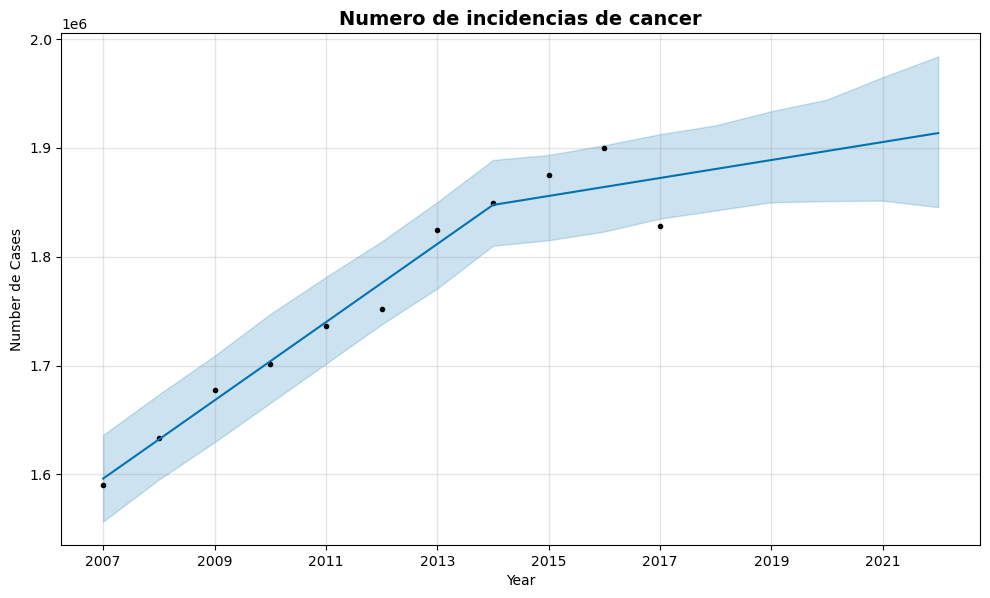

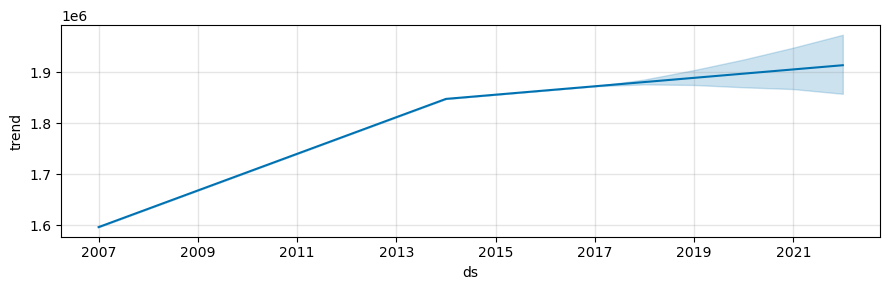

In [52]:
# Linear Trend
# PLot 1
fig1 = modelo1.plot(forecast1)
fig1.gca().set_title("Numero de incidencias de cancer", fontsize = 14, fontweight = 'bold')
fig1.gca().set_xlabel("Year")
fig1.gca().set_ylabel("Number de Cases")
plt.show()

# Plot 2
fig2 = modelo1.plot_components(forecast1)
plt.show()


In [53]:
print(forecast1)

           ds         trend    yhat_lower    yhat_upper   trend_lower  \
0  2007-01-01  1.596172e+06  1.556776e+06  1.636232e+06  1.596172e+06   
1  2008-01-01  1.632057e+06  1.595221e+06  1.673414e+06  1.632057e+06   
2  2009-01-01  1.668040e+06  1.629632e+06  1.708982e+06  1.668040e+06   
3  2010-01-01  1.703925e+06  1.665571e+06  1.747319e+06  1.703925e+06   
4  2011-01-01  1.739810e+06  1.701630e+06  1.781291e+06  1.739810e+06   
5  2012-01-01  1.775695e+06  1.737717e+06  1.813910e+06  1.775695e+06   
6  2013-01-01  1.811679e+06  1.770769e+06  1.850169e+06  1.811679e+06   
7  2014-01-01  1.847515e+06  1.810043e+06  1.888830e+06  1.847515e+06   
8  2015-01-01  1.855765e+06  1.815087e+06  1.893463e+06  1.855765e+06   
9  2016-01-01  1.864015e+06  1.823063e+06  1.902324e+06  1.864015e+06   
10 2017-01-01  1.872288e+06  1.834943e+06  1.912514e+06  1.872288e+06   
11 2017-12-31  1.880516e+06  1.842414e+06  1.920637e+06  1.875923e+06   
12 2018-12-31  1.888766e+06  1.849921e+06  1.933601

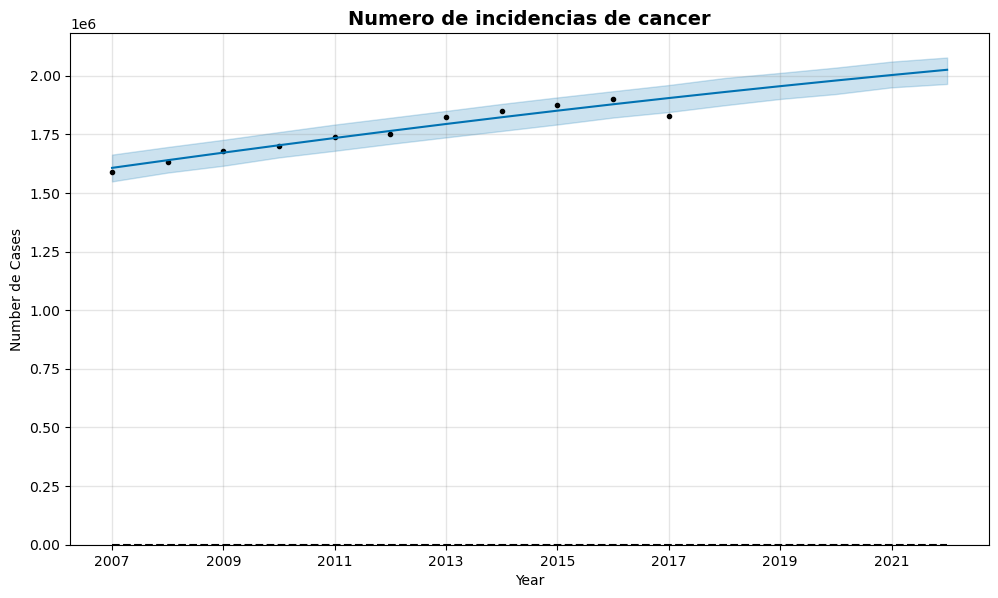

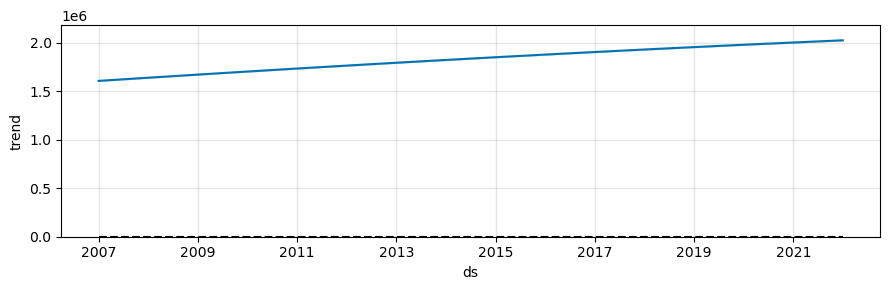

In [36]:
# Logistic Trend
# PLot 1
y_max = max(serie_df['y'].max(), forecast2['yhat_upper'].max())
fig1 = modelo2.plot(forecast2)
fig1.gca().set_title("Numero de incidencias de cancer", fontsize = 14, fontweight = 'bold')
fig1.gca().set_xlabel("Year")
fig1.gca().set_ylabel("Number de Cases")
fig1.gca().set_ylim(bottom=0, top=y_max * 1.05) # Add 5% padding
plt.show()

# Plot 2
fig2 = modelo2.plot_components(forecast2)

for ax in fig2.axes:
    # Apply the same Y-axis limit to all component plots
    ax.set_ylim(bottom=0, top=y_max * 1.05) # Add 5% padding for clarity
    
plt.show()

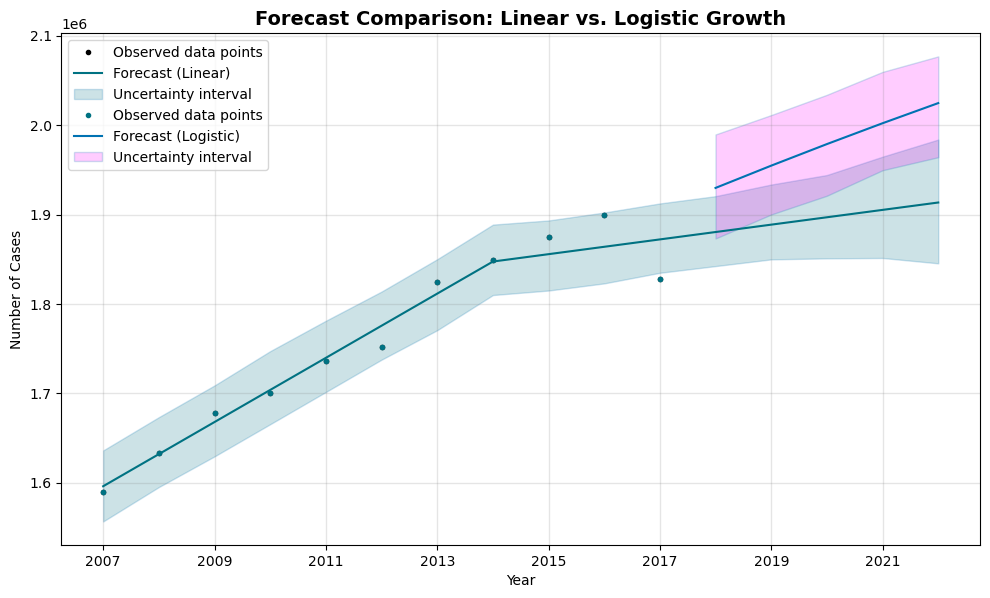

In [37]:
fig = modelo1.plot(forecast1)
ax = fig.gca()
modelo2.plot(
    future2_forecast,
    ax = ax,
    uncertainty = True,
    plot_cap = True,
    include_legend = True
)

lines = ax.lines
lines[-1].set_color('magenta')
lines[-1].set_label('Forecast (Logistic)')

# The uncertainty interval lines (yhat_lower and yhat_upper)
lines[-2].set_color('magenta')
lines[-3].set_color('magenta')

if True:
    ax.collections[-1].set_facecolor('magenta')
    ax.collections[-1].set_alpha(0.2)

lines[1].set_color("#007282") # Revert to Prophet's default line
lines[1].set_label('Forecast (Linear)')

# Set the color for the LINEAR Uncertainty Bounds (to blue)
lines[2].set_color('#007282') # Linear yhat_lower
lines[3].set_color('#0072B2') # Linear yhat_upper

ax.collections[-2].set_facecolor('#007282')
ax.collections[-2].set_alpha(0.2)

ax.set_title("Forecast Comparison: Linear vs. Logistic Growth", fontsize = 14, fontweight = 'bold')
ax.set_xlabel("Year")
ax.set_ylabel("Number of Cases")


ax.legend(loc = 'upper left', fontsize = 10)
plt.show()

# Definición de la cuadrícula de parametros (Grid Search)

In [38]:
# Definimos diferentes valores para el parámetro clave ´changepoint_prior_scale'
# Este parámetro controla la flexibilidad de la curva de tendencia.
# Valores más altos = tendencia más flexible (ḿas propensa al sobreajuste)
# Valores más bajos = tendencia más rígido (más propensa al subajuste)

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [10.0] # Mantenemos esta constante para simplificar la busqueda
}


# Crea una lista para todas las combinaciones de parámetros
parametros = list(ParameterGrid(param_grid))
print(f"\n--- 2. Probando {len(parametros)} combinaciones de parámetros ---")





--- 2. Probando 5 combinaciones de parámetros ---


# Validación cruzada de series de tiempo usando cortes de un año cada año después del entrenamiento inicial de 3 años y proyectando un pronóstico del año siguiente.

In [39]:
# Definimos los parámetros para la validación cruzada:
# - initial: El período inicial de entrenamiento (3 años).
# - period: La frecuencia con la que se realizan nuevos cortes (1 año).
# - horizon: El horizonte de pronóstico que queremos evaluar (1 año).
initial_train = '1095 days'  # 3 years * 365 days
cutoffs_period = '365 days'  # 1 year * 365 days
forecast_horizon = '365 days' # 1 year * 365 days

resultados_tuning = []

for params in parametros:
    print(f"\n--- Evaluando parámetros: {params} ---")
    
    # 3.1. Inicializar y Ajustar el Modelo con los Parámetros Actuales
    m = Prophet(
        growth='linear',
        yearly_seasonality=False, # Falso para datos anuales
        weekly_seasonality=False,
        daily_seasonality=False,
        # Asignar los parámetros a tunear
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale']
    )
    m.fit(serie_df)
    
    # 3.2. Realizar Validación Cruzada
    df_cv = cross_validation(
        model=m,
        initial=initial_train,
        period=cutoffs_period,
        horizon=forecast_horizon,
    )

    # 3.3. Obtener Métricas de Rendimiento
    # Calculamos la MAPE (Error Porcentual Absoluto Medio) para medir la precisión.
    df_metrics = performance_metrics(df_cv, metrics=['mape'], rolling_window=1)
    
    # Almacenar el resultado promedio
    mape_promedio = df_metrics['mape'].mean()
    
    # Guardar los resultados para su análisis posterior
    resultados_tuning.append({
        'parametros': params,
        'mape_promedio': mape_promedio
    })
    
    print(f"MAPE Promedio: {mape_promedio:.4f}")


19:09:02 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing



--- Evaluando parámetros: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0} ---


  0%|          | 0/7 [00:00<?, ?it/s]19:09:02 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing
19:09:02 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:00<00:00, 15.39it/s]19:09:02 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing
19:09:02 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:00<00:00, 14.18it/s]19:09:02 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing
19:09:02 - cmdstanpy - INFO - Chain [1] start processing
19:09:02 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:00<00:00, 13.90it/s]19:09:03 - cmdstanpy - INFO - Chain [1] start processing
19:09:03 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 7/7 [00:00<00:00, 14

MAPE Promedio: 0.0154

--- Evaluando parámetros: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0} ---


  0%|          | 0/7 [00:00<?, ?it/s]19:09:03 - cmdstanpy - INFO - Chain [1] start processing
19:09:06 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:03<00:19,  3.28s/it]19:09:06 - cmdstanpy - INFO - Chain [1] start processing
19:09:09 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:05<00:14,  2.88s/it]19:09:09 - cmdstanpy - INFO - Chain [1] start processing
19:09:09 - cmdstanpy - INFO - Chain [1] done processing
19:09:09 - cmdstanpy - INFO - Chain [1] start processing
19:09:09 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:06<00:03,  1.11s/it]19:09:09 - cmdstanpy - INFO - Chain [1] start processing
19:09:09 - cmdstanpy - INFO - Chain [1] done processing
19:09:09 - cmdstanpy - INFO - Chain [1] start processing
19:09:09 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:06<00:00,  1.62it/s]19:09:09 - cmdstanpy - INFO - Chain [1] start processing
19:09:09 - cmdstanpy - INFO - Chain [1] done pro

MAPE Promedio: 0.0161

--- Evaluando parámetros: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0} ---


  0%|          | 0/7 [00:00<?, ?it/s]19:09:09 - cmdstanpy - INFO - Chain [1] start processing
19:09:12 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:03<00:19,  3.24s/it]19:09:12 - cmdstanpy - INFO - Chain [1] start processing
19:09:15 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:06<00:16,  3.26s/it]19:09:15 - cmdstanpy - INFO - Chain [1] start processing
19:09:15 - cmdstanpy - INFO - Chain [1] done processing
19:09:15 - cmdstanpy - INFO - Chain [1] start processing
19:09:15 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:06<00:03,  1.25s/it]19:09:16 - cmdstanpy - INFO - Chain [1] start processing
19:09:16 - cmdstanpy - INFO - Chain [1] done processing
19:09:16 - cmdstanpy - INFO - Chain [1] start processing
19:09:16 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:06<00:00,  1.45it/s]19:09:16 - cmdstanpy - INFO - Chain [1] start processing
19:09:16 - cmdstanpy - INFO - Chain [1] done pro

MAPE Promedio: 0.0169

--- Evaluando parámetros: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0} ---


  0%|          | 0/7 [00:00<?, ?it/s]19:09:16 - cmdstanpy - INFO - Chain [1] start processing
19:09:19 - cmdstanpy - INFO - Chain [1] done processing
 14%|█▍        | 1/7 [00:02<00:17,  2.95s/it]19:09:19 - cmdstanpy - INFO - Chain [1] start processing
19:09:23 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:06<00:17,  3.56s/it]19:09:23 - cmdstanpy - INFO - Chain [1] start processing
19:09:23 - cmdstanpy - INFO - Chain [1] done processing
19:09:23 - cmdstanpy - INFO - Chain [1] start processing
19:09:23 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:07<00:04,  1.37s/it]19:09:23 - cmdstanpy - INFO - Chain [1] start processing
19:09:23 - cmdstanpy - INFO - Chain [1] done processing
19:09:23 - cmdstanpy - INFO - Chain [1] start processing
19:09:23 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:07<00:00,  1.33it/s]19:09:23 - cmdstanpy - INFO - Chain [1] start processing
19:09:23 - cmdstanpy - INFO - Chain [1] done pro

MAPE Promedio: 0.0162

--- Evaluando parámetros: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0} ---


  0%|          | 0/7 [00:00<?, ?it/s]19:09:23 - cmdstanpy - INFO - Chain [1] start processing
19:09:23 - cmdstanpy - INFO - Chain [1] done processing
19:09:23 - cmdstanpy - INFO - Chain [1] start processing
19:09:26 - cmdstanpy - INFO - Chain [1] done processing
 29%|██▊       | 2/7 [00:03<00:07,  1.57s/it]19:09:26 - cmdstanpy - INFO - Chain [1] start processing
19:09:26 - cmdstanpy - INFO - Chain [1] done processing
19:09:26 - cmdstanpy - INFO - Chain [1] start processing
19:09:26 - cmdstanpy - INFO - Chain [1] done processing
 57%|█████▋    | 4/7 [00:03<00:02,  1.48it/s]19:09:26 - cmdstanpy - INFO - Chain [1] start processing
19:09:26 - cmdstanpy - INFO - Chain [1] done processing
19:09:26 - cmdstanpy - INFO - Chain [1] start processing
19:09:26 - cmdstanpy - INFO - Chain [1] done processing
 86%|████████▌ | 6/7 [00:03<00:00,  2.53it/s]19:09:26 - cmdstanpy - INFO - Chain [1] start processing
19:09:26 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 7/7 [00:03<00:00,  2

MAPE Promedio: 0.0167


# Análisis de Resultados y Selección del Mejor Modelo

In [187]:
resultados_df = pd.DataFrame(resultados_tuning)

# Ordernar por MAPE para encontrar el mejor resultado (el valor más bajo)
mejor_modelo = resultados_df.sort_values(by = 'mape_promedio').iloc[0]

print("\n\n--- 4. Resumen de Resultados del Tuning (Ordenado por MAPE) ---")
print(resultados_df.sort_values(by='mape_promedio'))

print("\n--- ¡MEJOR CONFIGURACIÓN ENCONTRADA! ---")
print(f"Mejor 'changepoint_prior_scale': {mejor_modelo['parametros']['changepoint_prior_scale']}")
print(f"Mejor 'seasonality_prior_scale': {mejor_modelo['parametros']['seasonality_prior_scale']}")
print(f"MAPE Mínimo Obtenido: {mejor_modelo['mape_promedio']:.4f}")



--- 4. Resumen de Resultados del Tuning (Ordenado por MAPE) ---
                                          parametros  mape_promedio
0  {'changepoint_prior_scale': 0.001, 'seasonalit...       0.015448
1  {'changepoint_prior_scale': 0.01, 'seasonality...       0.016074
3  {'changepoint_prior_scale': 0.1, 'seasonality_...       0.016169
4  {'changepoint_prior_scale': 0.5, 'seasonality_...       0.016677
2  {'changepoint_prior_scale': 0.05, 'seasonality...       0.016932

--- ¡MEJOR CONFIGURACIÓN ENCONTRADA! ---
Mejor 'changepoint_prior_scale': 0.001
Mejor 'seasonality_prior_scale': 10.0
MAPE Mínimo Obtenido: 0.0154




--- 4. Resumen de Resultados del Tuning (Ordenado por MAPE) ---


NameError: name 'resultados_df' is not defined

# Ajustar el modelo final y generar el pronóstico

In [90]:
mejor_cps = mejor_modelo['parametros']['changepoint_prior_scale']

m_final = Prophet(
    growth='linear',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=mejor_cps
)
m_final.fit(serie_df)

21:06:43 - cmdstanpy - INFO - Chain [1] start processing
21:06:43 - cmdstanpy - INFO - Chain [1] done processing


/home/jsancheg/miniconda3/envs/cancer_incidences/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(



--- Pronóstico para los próximos 5 años con el Mejor Modelo ---
           ds          yhat    yhat_lower    yhat_upper
11 2017-12-31  1.933041e+06  1.896510e+06  1.969890e+06
12 2018-12-31  1.962477e+06  1.925699e+06  1.999685e+06
13 2019-12-31  1.991912e+06  1.956774e+06  2.028514e+06
14 2020-12-31  2.021429e+06  1.984132e+06  2.059840e+06
15 2021-12-31  2.050864e+06  2.014921e+06  2.086873e+06


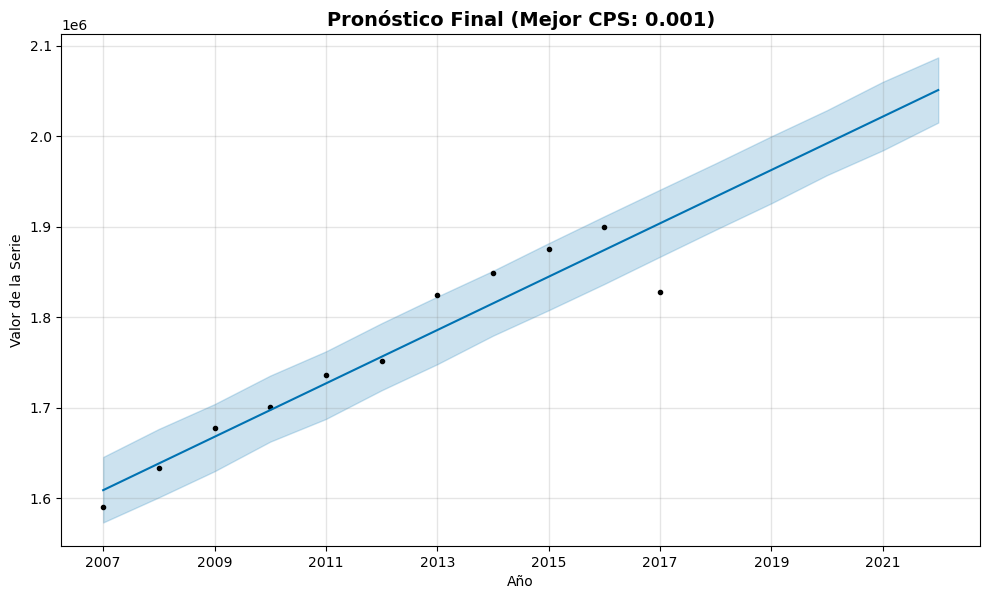

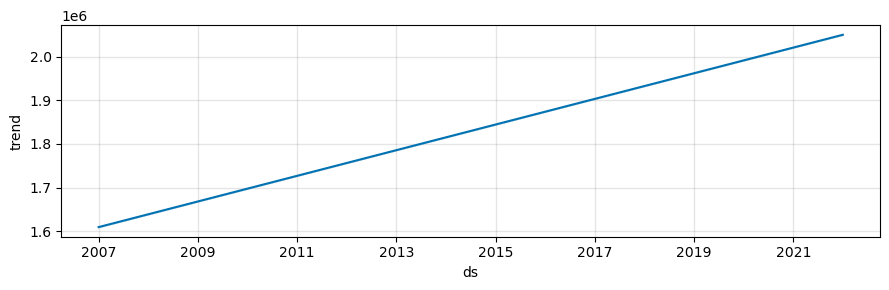

In [91]:
# Crear marco de datos futuro para 5 años
futuro = m_final.make_future_dataframe(periods = 5, freq = 'Y')
pronostico = m_final.predict(futuro)

print("\n--- Pronóstico para los próximos 5 años con el Mejor Modelo ---")
pronostico_final = pronostico[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)
print(pronostico_final)

# Visualización del pronóstico
fig1 = m_final.plot(pronostico)
fig1.gca().set_title(f"Pronóstico Final (Mejor CPS: {mejor_cps})", fontsize=14, fontweight='bold')
fig1.gca().set_xlabel("Año")
fig1.gca().set_ylabel("Valor de la Serie")
plt.show()

# Visualización de los componentes
fig2 = m_final.plot_components(pronostico)
plt.show()

In [92]:
import prophet
print(prophet.__version__)

1.1.5


In [93]:
print(prophet_df)

            y
ds           
2007  1590155
2008  1633154
2009  1677703
2010  1700972
2011  1736545
2012  1752191
2013  1824721
2014  1848966
2015  1875078
2016  1899646
2017  1827834


In [50]:
print(serie_df)
pd.to_datetime(serie_df['ds'])

           ds        y      cap  floor
0  2007-01-01  1590155  2500000      0
1  2008-01-01  1633154  2500000      0
2  2009-01-01  1677703  2500000      0
3  2010-01-01  1700972  2500000      0
4  2011-01-01  1736545  2500000      0
5  2012-01-01  1752191  2500000      0
6  2013-01-01  1824721  2500000      0
7  2014-01-01  1848966  2500000      0
8  2015-01-01  1875078  2500000      0
9  2016-01-01  1899646  2500000      0
10 2017-01-01  1827834  2500000      0


0    2007-01-01
1    2008-01-01
2    2009-01-01
3    2010-01-01
4    2011-01-01
5    2012-01-01
6    2013-01-01
7    2014-01-01
8    2015-01-01
9    2016-01-01
10   2017-01-01
Name: ds, dtype: datetime64[ns]

In [95]:
print(future1_forecast)

           ds          yhat    yhat_lower    yhat_upper  prediction_interval  \
11 2017-12-31  1.880516e+06  1.842158e+06  1.920968e+06         78809.750618   
12 2018-12-31  1.888766e+06  1.846599e+06  1.930119e+06         83520.775544   
13 2019-12-31  1.897016e+06  1.851558e+06  1.945230e+06         93672.780815   
14 2020-12-31  1.905289e+06  1.847695e+06  1.961670e+06        113975.667965   
15 2021-12-31  1.913539e+06  1.846110e+06  1.987329e+06        141219.756321   

    relative_uncertainty  
11              4.190859  
12              4.421977  
13              4.937902  
14              5.982068  
15              7.380031  


AttributeError: 'DataFrame' object has no attribute 'column'